In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # this is to silence tf warnings

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
import csv
import tensorflow_addons as tfa

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
BATCH_SIZE = 64
IMG_SIZE = 288, 432
PATH_SPECTRA = '<path to spectra files>'
PATH_TARGETS = '<path to targets>'
PATH_SAVE = '<model save path>'
SPLIT = 20_000
LEARNING_RATE = 1e-04
EPOCHS = 100
LAMBDA = 1e-02

In [4]:
img = keras.preprocessing.image.load_img(
    path='./spectra/0.jpg', 
    color_mode='grayscale',  # or 'rgb' 
    target_size=IMG_SIZE,
    interpolation="lanczos"
)
img

In [6]:
class CustomDataset(tf.keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, targets):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.targets = targets
        

    def __len__(self):
        return len(self.targets) // self.batch_size


    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_targets = self.targets[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size, dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            x[j] = img
            x[j] /= 255
        return x, batch_targets

In [ ]:
# results_list = []
# with open('./test.csv') as csvfile:
#     reader = csv.reader(csvfile)
#     for row in reader:
#         results_list.append(row)
# results_list
# np.array(results_list)

In [7]:
with open(PATH_TARGETS) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        target_list = [float(value) for value in row]
        targets = np.array(target_list)

In [8]:
input_img_paths = sorted(
    [
        os.path.join(PATH_SPECTRA, fname)
        for fname in os.listdir(PATH_SPECTRA)
        if fname.endswith((".jpg"))
    ], 
    key = lambda x: int(x.split('/')[-1].split('.')[0])
)

In [9]:
train_input_img_paths = input_img_paths[:SPLIT]
train_targets = targets[:SPLIT]
val_input_img_paths = input_img_paths[SPLIT:]
val_targets = targets[SPLIT:]

In [10]:
train = CustomDataset(
                    BATCH_SIZE,
                    IMG_SIZE,
                    train_input_img_paths,
                    train_targets,
            )
            
val = CustomDataset(
                    BATCH_SIZE,
                    IMG_SIZE,
                    val_input_img_paths,
                    val_targets,
            )

In [11]:
callback_01 = tf.keras.callbacks.ModelCheckpoint(
    PATH_SAVE,
    monitor="val_loss",
    mode = 'min',
    save_best_only=True,
)

In [12]:
L1_reg = tf.keras.regularizers.L1(l1=LAMBDA)
L2_reg = tf.keras.regularizers.L2(l2=LAMBDA)

In [13]:
inputs = Input(shape=IMG_SIZE+(1,))

conv1 = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
pool1= MaxPooling2D(2, strides=2, padding="same")(conv1)

conv2 = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(pool1)
pool2= MaxPooling2D(2, strides=2, padding="same")(conv2)

conv3 = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(pool2)
pool3= MaxPooling2D(2, strides=2, padding="same")(conv3)

flat = Flatten()(pool3)

dense1 = Dense(
    units=50,
    activation='relu',
    kernel_regularizer=L1_reg,
    activity_regularizer=L2_reg,
    )(flat)

output = Dense(
    units=1,
    )(dense1)

In [14]:
model = tf.keras.Model(inputs=inputs, outputs=output)

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
    ),
    loss='mean_squared_error',
    metrics = [tfa.metrics.RSquare()],
)

In [1]:
# model.summary()

In [2]:
history = model.fit(
    train,
    validation_data=val,
    epochs=200,
    callbacks=[callback_01,],
    verbose=1
)

In [19]:
conv_layers = ['conv2d', 'conv2d_1', 'conv2d_2']

## Saliency map

In [20]:
import matplotlib.pyplot as plt

In [21]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
    grads = tape.gradient(preds, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [47]:
test_image_path = './spectra/1000.jpg'

In [48]:
real_image = load_img(test_image_path, target_size = IMG_SIZE, color_mode='grayscale')

In [49]:
array = img_to_array(real_image)
array = np.expand_dims(array, axis=0)/255.

In [50]:
activations=[]
for conv_layer in conv_layers:
    heatmap = make_gradcam_heatmap(array, model, conv_layer)
    activations.append(heatmap)

In [99]:
# real_image = load_img(test_image_path, target_size = IMG_SIZE, color_mode='grayscale')

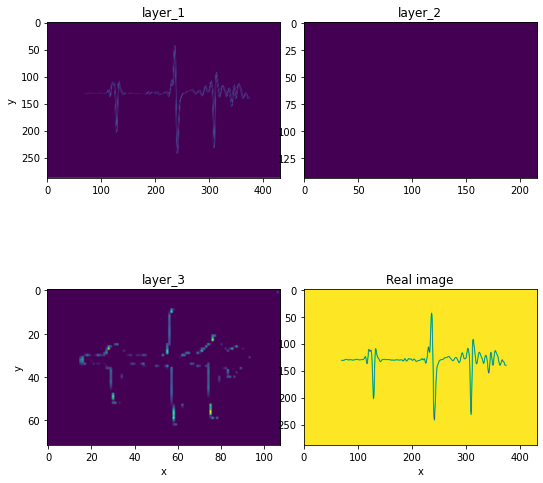

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=False,\
    sharey=False, squeeze=False)

axes[0, 0].set_title("layer_1")
axes[0, 0].imshow(activations[0])

axes[0, 1].set_title("layer_2")
axes[0, 1].imshow(activations[1])

axes[1, 0].set_title("layer_3")
axes[1, 0].imshow(activations[2])

axes[1, 1].set_title("Real image")
axes[1, 1].imshow(real_image)

axes[1, 1].set_xlabel("x")
axes[1, 0].set_xlabel("x")
axes[0, 0].set_ylabel("y")
axes[1, 0].set_ylabel("y")

plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95,\
    wspace=0.1, hspace=0.2)

In [56]:
from PIL import Image

In [52]:
import matplotlib.cm as cm

In [57]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.6):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE, interpolation='lanczos')
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path))



In [58]:
heatmap = make_gradcam_heatmap(array, model, 'conv2d_2')

In [3]:
save_and_display_gradcam(img_path=test_image_path, heatmap=heatmap)